In [ ]:
#!jupyter nbconvert --to=python pCO2SOCAT_python3.ipynb

# After changes in the script using Jupyter notebook, save the notebook, run this line, and clear the output.

In [1]:
class pCO2comp:
    '''
    class pCO2SOCATcomp(runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 mapproj='pc',savefig=False,layerwise=False)
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,ncpath,first_year,last_year,
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.ncpath = ncpath
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array

        import matplotlib.pyplot as plt
        import numpy as np
        from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf
        
        from plot_Taylor_normalized import plt_Taylor_norm
    
        # derive SOCAT mapping projection -------------------------------------------------------------------------------------
        if(self.mapproj == 'pc'): projection = ccrs.PlateCarree()
        elif(self.mapproj == 'rob'): projection = ccrs.Robinson()
        else: print('Projection for plotting SOCAT data is not supported! Choose "pc" or "rob".')
            
        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(meshpath)
        years = [self.fyear, self.lyear]
        

        # load FESOM data -------------------------------------------------------------------------------------
         # check variables
        #NCfesom = self.resultpath + '/pCO2s.'+self.runname+'.'+str(self.fyear)+'.nc'
        #!ncdump -h $NCfesom

        ### FESOM data only 2d!
        
        labelfesom = 'FESOM pCO$_2$ {0}-{1}'.format(self.fyear,self.lyear)
        unitfesom = 'pCO$_2$ [$\mu$atm]' # equals to mumol/L
        
        pCO2fesom = pf.get_data(resultpath, "pCO2s", years, mesh, 
                               how="mean", compute=True, runid=self.runname, silent=True)
        #print(np.shape(pCO2fesom))

        #-----------------------------------------------
        # Reading CO2 flux data from SOCAT =========================================

        if (self.fyear < 1970):
            print("\n***\n***no SOCAT data to be plotted before 1970\n***")  
            
            # plot only FESOM ------------------------------------                    
            print('\nPlotting pCO2\nFESOM min = {0}, max = {1}'.format(
                    np.nanmin(pCO2fesom),np.nanmax(pCO2fesom)))

            fig_data = pf.plot(mesh, [pCO2fesom], 
                    rowscol= (1,1),
                    #levels = (0,35,36),
                    units=unitfesom, 
                    mapproj=self.mapproj, # robinson projection takes more time!
                    titles=[labelfesom],
                    figsize = (10,10)
                   )
            
            # fig export  
            if(self.savefig==True):
                plt.savefig(self.savepath+self.runname+'_'+'pCO2_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False) 
            
        else:
            ncfile     = self.ncpath
            f          = Dataset(ncfile, 'r')
            # fco2_ave_unwtd:units = "uatm"
            SOCATfco2_tmp  = f.variables['fco2_ave_unwtd'][:,:,:]      # fCO2 observations
            SOCATfco2_tmp  = np.ma.filled(SOCATfco2_tmp, np.nan)  # From masked array to numpy array
            SOCATfco2_tmp = np.transpose(SOCATfco2_tmp, (2, 1, 0)) # now ordered lon, lat, time
            lon_socat  = f.variables['xlon'][:]           # -180 to 180, okay.
            # print min(lon_socat), max(lon_socat)
            lat_socat  = f.variables['ylat'][:]
            days_socat = f.variables['tmnth'][:]          # days since 1970-01-01 00:00:00
        
            year_socat = days_socat/365+1970              # fractional years
        
            #print "type of SOCATfco2_tmp: ", type(SOCATfco2_tmp)  # all <type 'numpy.ndarray'>, okay.
            #print "type of lon_socat: ", type(lon_socat)
            #print "type of lat_socat: ", type(lat_socat)
            #print "type of days_socat: ", type(days_socat)
            #print "type of year_socat: ", type(year_socat)
        
            SOCATfco2 = SOCATfco2_tmp[:,:,(year_socat>=self.fyear)&(year_socat<(self.lyear+1))]
        
            # calculate mean over that time-period:
            SOCATfco2_ave = np.nanmean(SOCATfco2,axis=2)#,dtype=ndarray)
            ind   = ~np.isnan(SOCATfco2_ave) 
            
            # ==============================================================================
            ## Interpolation to fesom's grid

            # transpose
            SOCATfco2_ave = np.transpose(SOCATfco2_ave, (1, 0)) # now ordered lat, lon,
            
            lonbefore, latbefore = np.meshgrid(lon_socat,lat_socat)               
            
            data1 = griddata((lonbefore.ravel(),latbefore.ravel()), SOCATfco2_ave.ravel(), (mesh.x2,mesh.y2), method='nearest')
            SOCATfco2_ave_int = np.ma.filled(data1, np.nan)
            #print(np.shape(SOCATfco2_ave_int))
  
            # ==============================================================================
             # plot FESOM and SOCAT                     
            print('\nPlotting pCO2\nFESOM min = {0}, max = {1}'.format(
                    np.nanmin(pCO2fesom),np.nanmax(pCO2fesom)))

            
            print('SOCAT min = {0}, max = {1}'.format(
                np.nanmin(SOCATfco2_ave),np.nanmax(SOCATfco2_ave)))
            
            labelsocat = 'SOCAT pCO$_2$ '+str(years[0])+' to '+str(years[1]) 
            unitsocat = '[$\mu$atm]'
            
            if False:
                # SOCAT on original grid
                fig_socat = plt.figure(figsize=(10,10))
                #ax = plt.axes(projection=projection)
                im = plt.pcolor(SOCATfco2_ave, cmap='RdYlGn_r',vmin=150,vmax=600)#, transform = ccrs.PlateCarree())
                cbar = fig_socat.colorbar(im,orientation="horizontal", pad=0.1, shrink=0.8)
                #ax.coastlines()
                cbar.set_label(unitsocat)
                plt.title(labelsocat + ' (raw data on original grid)')
            
            fig_comp = pf.plot(mesh, [SOCATfco2_ave_int-pCO2fesom], 
                rowscol= (1,1),
                levels = (-100,200,76),
                units=unitsocat, 
                #cmap='RdBu_r',
                mapproj=self.mapproj, # robinson projection takes more time!
                titles=['Differences air-sea CO$_2$ flux (model-data)'],
                figsize = (10,10)
               )
            
            fig_comp = pf.plot(mesh, [SOCATfco2_ave_int,pCO2fesom], 
                rowscol= (2,1),
                levels = (150,600,91),
                units=unitsocat, 
                #cmap='RdBu_r',
                mapproj=self.mapproj, # robinson projection takes more time!
                titles=[labelsocat, labelfesom],
                figsize = (10,10)
               )
            
            # fig export  -------------------------------------------------------------------------------------
            if(self.savefig==True):
                plt.savefig(self.savepath+self.runname+'_'+'pCO2_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False) 
            
            # statistics  -------------------------------------------------------------------------------------            
            # preparation of datasets
            aux = np.where(np.isfinite(SOCATfco2_ave_int))
            
            title = 'Taylor Diagram for pCO$_2$'
            plt_Taylor_norm(SOCATfco2_ave_int[aux],pCO2fesom[aux],mask=False,title=title)
            
            # fig export  
            if(self.savefig==True):                
                plt.savefig(self.savepath+self.runname+'_'+'pCO2_Taylor'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                        dpi = 300, bbox_inches='tight')
            plt.show(block=False)
            
         



<ipython-input-1-1f528d26cb5c>:107: RuntimeWarning: Mean of empty slice
  SOCATfco2_ave = np.nanmean(SOCATfco2,axis=2)#,dtype=ndarray)



Plotting pCO2
FESOM min = 142.17611694335938, max = 410.1114807128906
SOCAT min = 102.9250259399414, max = 4058.99951171875


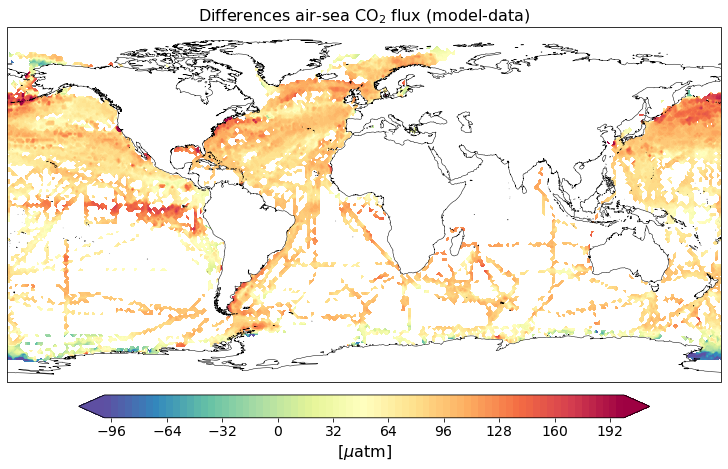

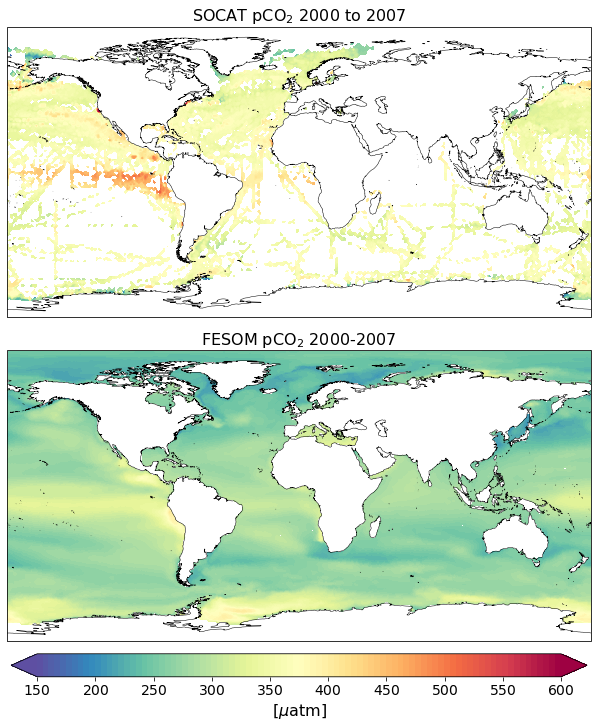

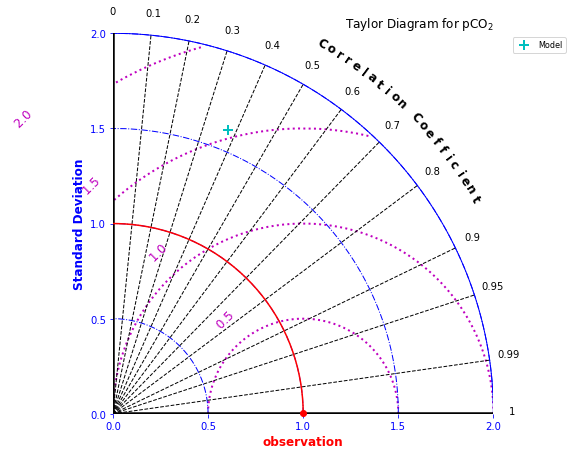

In [3]:
### TESTING ###
if __name__ == "__main__":
    
    if True:
        runid = 'fesom'
        layerwise = False
        resultpath = '/work/ollie/ogurses/output_f2r2/THIRD_RUN'
        meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

        # period of analysis 
        first_year = 2000
        last_year  = 2007

    else:
        runid      =  'mo1'
        layerwise    = False
        resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
        meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

        # period of analysis 
        first_year = 1948
        last_year  = 1950

    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    # SOCAT ------------------------------------------------------------------------------------    
    ncfilepCO2               = '/work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc'
    ncpath = ncfilepCO2
    #!ncdump -h $ncpath
    
    # now test:
    test = pCO2comp(runid,resultpath,savepath,meshpath,ncpath,first_year,last_year,savefig=False)